### Importação das bibliotecas necessárias

In [107]:
import tensorflow as tf
import numpy as np
import pandas as pd
import six

from random import randint

from sklearn.model_selection import train_test_split

from skimage.transform import resize
from scipy.ndimage import morphology as mp

from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model, load_img, Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.keras.utils import get_source_inputs
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.layers import Conv2D, UpSampling2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.layers import Activation, SpatialDropout2D
from tensorflow.keras.layers import Input, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import img_to_array

from tqdm import tqdm_notebook

from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras import initializers
from keras import regularizers
from keras import constraints
from keras import backend as K
from keras.regularizers import l2
from keras.applications import VGG16

### Verifica se a GPU está disponível para uso pelo TensorFlow

In [108]:
print("GPU Available" if len(tf.config.list_physical_devices('GPU')) > 0 else "GPU Not Detected")

GPU Available


In [109]:
from os import listdir

image_path = './images_cut/'
labels_path = './labels_cut/'

file_names = [filename for filename in listdir(image_path)]
train_files, val_files = train_test_split(file_names, test_size=0.2, random_state=42)

train_imgs= [image_path + i for i in train_files]
train_masks= [ labels_path + i for i in train_files]

val_imgs = [image_path + i for i in val_files]
val_masks = [labels_path + i for i in val_files]

In [110]:
print("Training images:", len(train_imgs))
print("Validation images:", len(val_imgs))

Training images: 80
Validation images: 20


In [111]:
img_size_ori = 101
img_size_target = (224, 840)
img_w_target = 224
img_h_target = 224

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_w_target, img_h_target), mode='constant', preserve_range=True)

def downsample(img):
    return resize(img, (img_w_target, img_h_target), mode='constant', preserve_range=True)

### Definição do gerador de dados

Será necessário para evitar que todas as imagens sejam carregadas em memória.
Fonte: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [112]:
class DataGenerator(Sequence):

    def __init__(self, images, labels, batch_size=16, dim=(224,224,3), shuffle=True):
        'Initialization'
        self.dim = dim
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        list_IDs_temp = [k for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        batch_imgs = list()
        batch_labels = list()

        for i in list_IDs_temp:
            img = load_img(self.images[i], target_size=self.dim, grayscale=False)
            img = img_to_array(img)/255
            batch_imgs.append(img)
            label = load_img(self.labels[i], target_size=self.dim, grayscale=False)
            label = img_to_array(label)[:,:,0]
            label = label != 0
            label = mp.binary_erosion(mp.binary_erosion(label))
            label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))
            label = np.expand_dims((label)*1 , axis=2)
            batch_labels.append(label)

        return np.array(batch_imgs, dtype = np.float32), np.array(batch_labels , dtype = np.float32 )

In [113]:
batch_size = 16
train_generator = DataGenerator(train_imgs, train_masks, batch_size=batch_size, dim=(224,224,3), shuffle=True)
train_generator.__getitem__(1)
train_steps = train_generator.__len__()

<ipython-input-112-b627626ca26f>:41: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_erosion(mp.binary_erosion(label))
<ipython-input-112-b627626ca26f>:42: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


In [114]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
import seaborn as sns
sns.set_style("white")

def display_sample(data_tuple, img_shape):
    X,y = data_tuple
    plt.figure(figsize=(8,8))
    plt.subplot(121)
    plt.imshow(X[0])
    plt.subplot(122)
    plt.imshow(np.reshape(y[0], img_shape))

<ipython-input-112-b627626ca26f>:41: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_erosion(mp.binary_erosion(label))
<ipython-input-112-b627626ca26f>:42: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


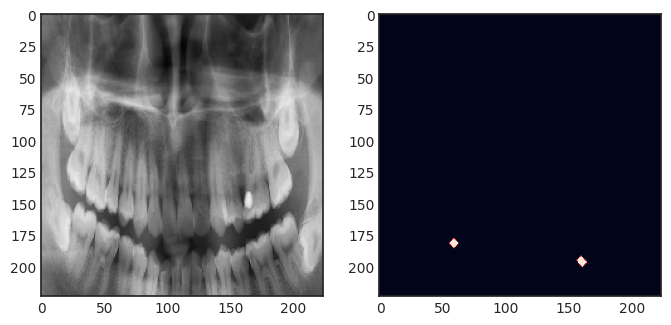

In [115]:
display_sample(train_generator.__getitem__(1), (224,224))

<ipython-input-112-b627626ca26f>:41: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_erosion(mp.binary_erosion(label))
<ipython-input-112-b627626ca26f>:42: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


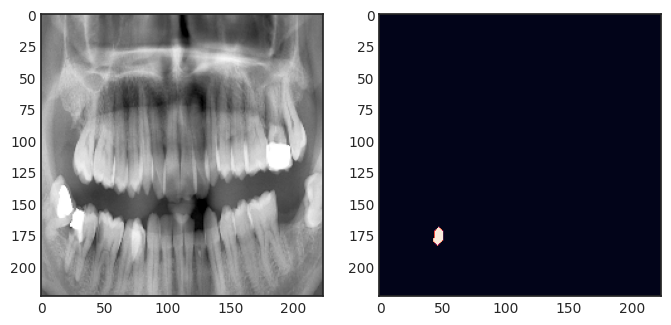

In [116]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

val_generator = DataGenerator(val_imgs, val_masks, batch_size=batch_size, dim=(224,224,3), shuffle=True)
val_steps = val_generator.__len__()
val_images = val_generator.images

display_sample(val_generator.__getitem__(0), (224, 224))

# Modelo de U-Net com backbone constrúido com VGG16 pré-treinada

In [117]:
def getLayerIndexByName(model, layername):
    for idx, layer in enumerate(model.layers):
        if layer.name == layername:
            return idx

In [135]:
def conv_block(inputs, filterCount, kernel_size=3):
    x = Conv2D(filterCount, kernel_size, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filterCount, kernel_size, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(inputs, skip, filter_count):

    x = Conv2D(
        filter_count,
        2,
        activation = 'relu',
        padding = 'same',
        kernel_initializer = 'he_normal')(UpSampling2D(size=(2,2))(inputs))

    x = Conv2D(
        filter_count,
        3,
        activation = 'relu',
        padding = 'same',
        kernel_initializer = 'he_normal')(x)

    x = Conv2D(
        filter_count,
        3,
        activation = 'relu',
        padding = 'same',
        kernel_initializer = 'he_normal')(x)

    x = BatchNormalization()(x)

    x = concatenate([x, skip])

    return x

In [136]:
def UnetVgg(input_shape):
    inputs = Input(input_shape)
    print(inputs.shape)
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor = inputs)

    skip1 = vgg16.get_layer("block1_conv2").output
    skip2 = vgg16.get_layer("block2_conv2").output
    skip3 = vgg16.get_layer("block3_conv3").output
    skip4 = vgg16.get_layer("block4_conv3").output

    center = vgg16.get_layer("block5_conv3").output

    d1 = decoder_block(center,skip4,512)
    d2 = decoder_block(d1,skip3,256)
    d3 = decoder_block(d2,skip2,128)
    d4 = decoder_block(d3,skip1,64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model

(None, 224, 224, 3)
Model: "VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_5[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                    

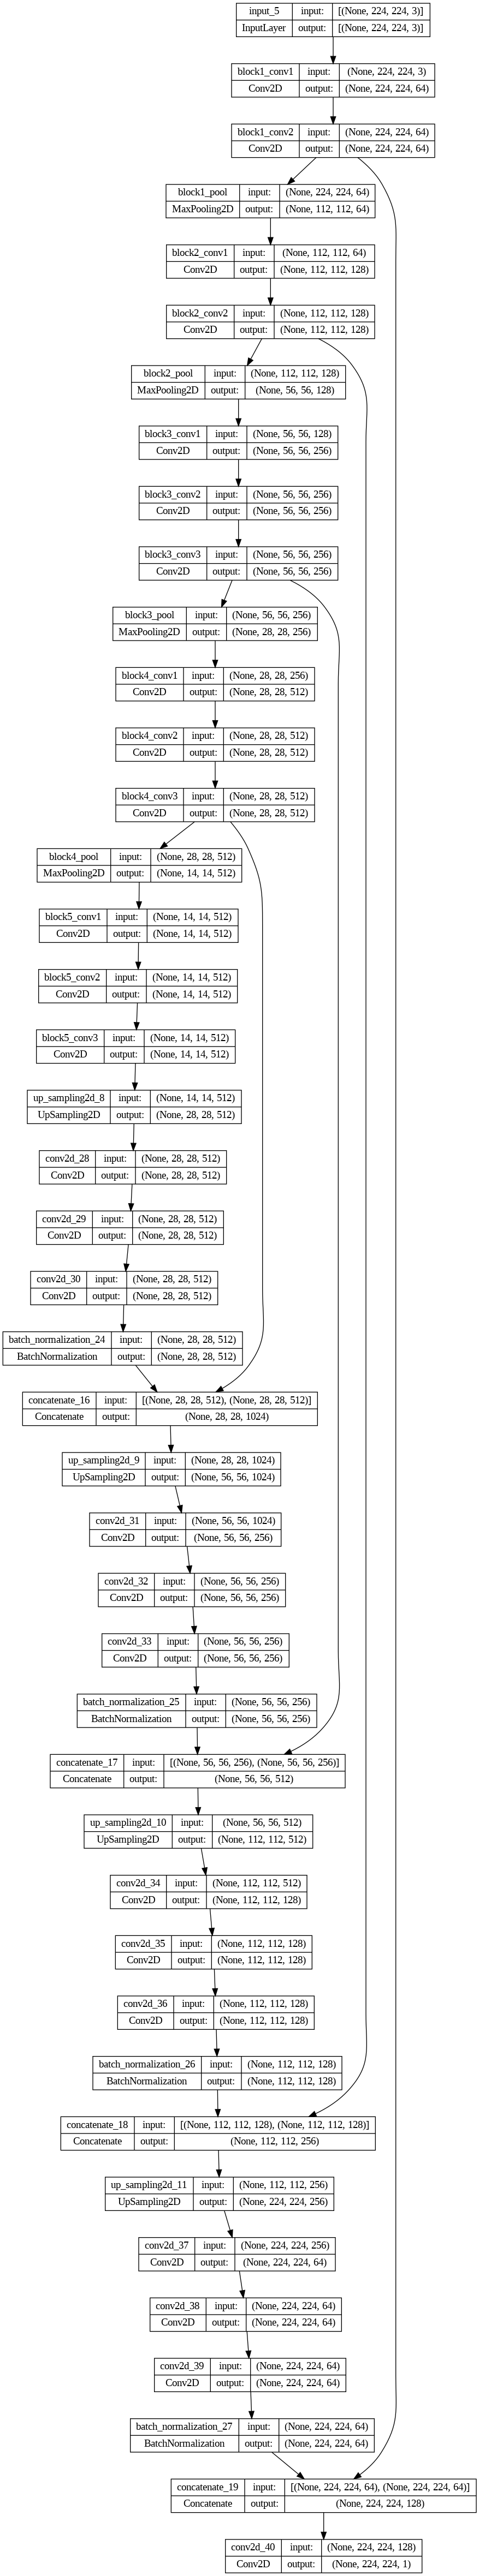

In [137]:
model = UnetVgg(input_shape=(224,224, 3))
model.summary()
plot_model(model, show_shapes=True)

### Métricas de perda customizadas

O índice de Jaccard é útil para situações onde as classes são desbalanceadas.

In [121]:
from keras.losses import binary_crossentropy

def jaccard_distance_loss(y_true, y_pred):
    # https://en.wikipedia.org/wiki/Jaccard_index
    smooth = 1
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    print("y_true_f", y_true_f)
    print("Score", 1. - score)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    print("y_true, y_pred", y_true, y_pred)
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [138]:
model.compile(optimizer='adam', loss=dice_loss, metrics = ['accuracy'])
mc = ModelCheckpoint(mode='max', filepath='top.weights.h5', monitor='dice_coef',save_best_only='True', save_weights_only='True', verbose=1)
# es = EarlyStopping(mode='max', monitor='val_dice_coef', patience=3, verbose=1)
callbacks = [mc]
model.metrics_names

[]

In [123]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [139]:
model_history = model.fit(train_generator, steps_per_epoch=train_steps,epochs=60,callbacks=callbacks,validation_data=val_generator,validation_steps=val_steps)

<ipython-input-112-b627626ca26f>:41: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_erosion(mp.binary_erosion(label))
<ipython-input-112-b627626ca26f>:42: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


Epoch 1/60
y_true_f Tensor("dice_loss/Reshape:0", shape=(None,), dtype=float32)
Score Tensor("dice_loss/sub:0", shape=(), dtype=float32)
y_true_f Tensor("dice_loss/Reshape:0", shape=(None,), dtype=float32)
Score Tensor("dice_loss/sub:0", shape=(), dtype=float32)
5/5 [==============================] - ETA: 0s - loss: 0.9819 - accuracy: 0.5606y_true_f Tensor("dice_loss/Reshape:0", shape=(None,), dtype=float32)
Score Tensor("dice_loss/sub:0", shape=(), dtype=float32)


5/5 [==============================] - 14s 830ms/step - loss: 0.9819 - accuracy: 0.5606 - val_loss: 0.9870 - val_accuracy: 0.8044
Epoch 2/60
5/5 [==============================] - ETA: 0s - loss: 0.8873 - accuracy: 0.9856

5/5 [==============================] - 4s 845ms/step - loss: 0.8873 - accuracy: 0.9856 - val_loss: 0.9855 - val_accuracy: 0.5094
Epoch 3/60
5/5 [==============================] - ETA: 0s - loss: 0.8078 - accuracy: 0.9946

5/5 [==============================] - 4s 841ms/step - loss: 0.8078 - accuracy: 0.9946 - val_loss: 0.9913 - val_accuracy: 0.0095
Epoch 4/60
5/5 [==============================] - ETA: 0s - loss: 0.7396 - accuracy: 0.9941

5/5 [==============================] - 4s 824ms/step - loss: 0.7396 - accuracy: 0.9941 - val_loss: 0.9909 - val_accuracy: 0.0892
Epoch 5/60
5/5 [==============================] - ETA: 0s - loss: 0.6313 - accuracy: 0.9960

5/5 [==============================] - 4s 841ms/step - loss: 0.6313 - accuracy: 0.9960 - val_loss: 0.9788 - val_accuracy: 0.6388
Epoch 6/60
5/5 [==============================] - ETA: 0s - loss: 0.6044 - accuracy: 0.9957

5/5 [==============================] - 4s 812ms/step - loss: 0.6044 - accuracy: 0.9957 - val_loss: 0.9862 - val_accuracy: 0.5452
Epoch 7/60
5/5 [==============================] - ETA: 0s - loss: 0.5693 - accuracy: 0.9965

5/5 [==============================] - 4s 806ms/step - loss: 0.5693 - accuracy: 0.9965 - val_loss: 0.9915 - val_accuracy: 0.1076
Epoch 8/60
5/5 [==============================] - ETA: 0s - loss: 0.5102 - accuracy: 0.9964

5/5 [==============================] - 4s 837ms/step - loss: 0.5102 - accuracy: 0.9964 - val_loss: 0.9906 - val_accuracy: 0.1723
Epoch 9/60
5/5 [==============================] - ETA: 0s - loss: 0.4510 - accuracy: 0.9972

5/5 [==============================] - 4s 811ms/step - loss: 0.4510 - accuracy: 0.9972 - val_loss: 0.6951 - val_accuracy: 0.9914
Epoch 10/60
5/5 [==============================] - ETA: 0s - loss: 0.4221 - accuracy: 0.9971

5/5 [==============================] - 4s 843ms/step - loss: 0.4221 - accuracy: 0.9971 - val_loss: 0.6047 - val_accuracy: 0.9961
Epoch 11/60
5/5 [==============================] - ETA: 0s - loss: 0.4082 - accuracy: 0.9972

5/5 [==============================] - 4s 827ms/step - loss: 0.4082 - accuracy: 0.9972 - val_loss: 0.9376 - val_accuracy: 0.9272
Epoch 12/60
5/5 [==============================] - ETA: 0s - loss: 0.3891 - accuracy: 0.9973

5/5 [==============================] - 4s 838ms/step - loss: 0.3891 - accuracy: 0.9973 - val_loss: 0.6489 - val_accuracy: 0.9963
Epoch 13/60
5/5 [==============================] - ETA: 0s - loss: 0.3826 - accuracy: 0.9972

5/5 [==============================] - 4s 818ms/step - loss: 0.3826 - accuracy: 0.9972 - val_loss: 0.8732 - val_accuracy: 0.9962
Epoch 14/60
5/5 [==============================] - ETA: 0s - loss: 0.3551 - accuracy: 0.9976

5/5 [==============================] - 4s 814ms/step - loss: 0.3551 - accuracy: 0.9976 - val_loss: 0.4586 - val_accuracy: 0.9966
Epoch 15/60
5/5 [==============================] - ETA: 0s - loss: 0.3477 - accuracy: 0.9975

5/5 [==============================] - 4s 825ms/step - loss: 0.3477 - accuracy: 0.9975 - val_loss: 0.5493 - val_accuracy: 0.9957
Epoch 16/60
5/5 [==============================] - ETA: 0s - loss: 0.3479 - accuracy: 0.9976

5/5 [==============================] - 4s 824ms/step - loss: 0.3479 - accuracy: 0.9976 - val_loss: 0.6747 - val_accuracy: 0.9914
Epoch 17/60
5/5 [==============================] - ETA: 0s - loss: 0.3268 - accuracy: 0.9978

5/5 [==============================] - 4s 802ms/step - loss: 0.3268 - accuracy: 0.9978 - val_loss: 0.5469 - val_accuracy: 0.9957
Epoch 18/60
5/5 [==============================] - ETA: 0s - loss: 0.2876 - accuracy: 0.9979

5/5 [==============================] - 4s 817ms/step - loss: 0.2876 - accuracy: 0.9979 - val_loss: 0.6361 - val_accuracy: 0.9950
Epoch 19/60
5/5 [==============================] - ETA: 0s - loss: 0.3049 - accuracy: 0.9979

5/5 [==============================] - 4s 840ms/step - loss: 0.3049 - accuracy: 0.9979 - val_loss: 0.5365 - val_accuracy: 0.9960
Epoch 20/60
5/5 [==============================] - ETA: 0s - loss: 0.2865 - accuracy: 0.9979

5/5 [==============================] - 4s 808ms/step - loss: 0.2865 - accuracy: 0.9979 - val_loss: 0.6273 - val_accuracy: 0.9913
Epoch 21/60
5/5 [==============================] - ETA: 0s - loss: 0.2834 - accuracy: 0.9979

5/5 [==============================] - 4s 839ms/step - loss: 0.2834 - accuracy: 0.9979 - val_loss: 0.4769 - val_accuracy: 0.9963
Epoch 22/60
5/5 [==============================] - ETA: 0s - loss: 0.2630 - accuracy: 0.9982

5/5 [==============================] - 4s 819ms/step - loss: 0.2630 - accuracy: 0.9982 - val_loss: 0.6204 - val_accuracy: 0.9969
Epoch 23/60
5/5 [==============================] - ETA: 0s - loss: 0.2460 - accuracy: 0.9982

5/5 [==============================] - 4s 807ms/step - loss: 0.2460 - accuracy: 0.9982 - val_loss: 0.4908 - val_accuracy: 0.9962
Epoch 24/60
5/5 [==============================] - ETA: 0s - loss: 0.2403 - accuracy: 0.9982

5/5 [==============================] - 4s 813ms/step - loss: 0.2403 - accuracy: 0.9982 - val_loss: 0.4864 - val_accuracy: 0.9970
Epoch 25/60
5/5 [==============================] - ETA: 0s - loss: 0.2228 - accuracy: 0.9984

5/5 [==============================] - 4s 816ms/step - loss: 0.2228 - accuracy: 0.9984 - val_loss: 0.5218 - val_accuracy: 0.9966
Epoch 26/60
5/5 [==============================] - ETA: 0s - loss: 0.2227 - accuracy: 0.9983

5/5 [==============================] - 4s 805ms/step - loss: 0.2227 - accuracy: 0.9983 - val_loss: 0.6956 - val_accuracy: 0.9965
Epoch 27/60
5/5 [==============================] - ETA: 0s - loss: 0.2168 - accuracy: 0.9984

5/5 [==============================] - 4s 822ms/step - loss: 0.2168 - accuracy: 0.9984 - val_loss: 0.4884 - val_accuracy: 0.9968
Epoch 28/60
5/5 [==============================] - ETA: 0s - loss: 0.2227 - accuracy: 0.9984

5/5 [==============================] - 4s 817ms/step - loss: 0.2227 - accuracy: 0.9984 - val_loss: 0.6565 - val_accuracy: 0.9968
Epoch 29/60
5/5 [==============================] - ETA: 0s - loss: 0.2152 - accuracy: 0.9985

5/5 [==============================] - 4s 824ms/step - loss: 0.2152 - accuracy: 0.9985 - val_loss: 0.4845 - val_accuracy: 0.9969
Epoch 30/60
5/5 [==============================] - ETA: 0s - loss: 0.2062 - accuracy: 0.9985

5/5 [==============================] - 4s 810ms/step - loss: 0.2062 - accuracy: 0.9985 - val_loss: 0.5650 - val_accuracy: 0.9970
Epoch 31/60
5/5 [==============================] - ETA: 0s - loss: 0.1988 - accuracy: 0.9986

5/5 [==============================] - 4s 809ms/step - loss: 0.1988 - accuracy: 0.9986 - val_loss: 0.5453 - val_accuracy: 0.9966
Epoch 32/60
5/5 [==============================] - ETA: 0s - loss: 0.1876 - accuracy: 0.9986

5/5 [==============================] - 4s 812ms/step - loss: 0.1876 - accuracy: 0.9986 - val_loss: 0.5648 - val_accuracy: 0.9967
Epoch 33/60
5/5 [==============================] - ETA: 0s - loss: 0.1843 - accuracy: 0.9986

5/5 [==============================] - 4s 811ms/step - loss: 0.1843 - accuracy: 0.9986 - val_loss: 0.7361 - val_accuracy: 0.9965
Epoch 34/60
5/5 [==============================] - ETA: 0s - loss: 0.1916 - accuracy: 0.9986

5/5 [==============================] - 4s 803ms/step - loss: 0.1916 - accuracy: 0.9986 - val_loss: 0.7140 - val_accuracy: 0.9965
Epoch 35/60
5/5 [==============================] - ETA: 0s - loss: 0.1940 - accuracy: 0.9986

5/5 [==============================] - 4s 810ms/step - loss: 0.1940 - accuracy: 0.9986 - val_loss: 0.6587 - val_accuracy: 0.9968
Epoch 36/60
5/5 [==============================] - ETA: 0s - loss: 0.1914 - accuracy: 0.9986

5/5 [==============================] - 4s 821ms/step - loss: 0.1914 - accuracy: 0.9986 - val_loss: 0.7343 - val_accuracy: 0.9965
Epoch 37/60
5/5 [==============================] - ETA: 0s - loss: 0.1877 - accuracy: 0.9986

5/5 [==============================] - 4s 804ms/step - loss: 0.1877 - accuracy: 0.9986 - val_loss: 0.9020 - val_accuracy: 0.9962
Epoch 38/60
5/5 [==============================] - ETA: 0s - loss: 0.1805 - accuracy: 0.9987

5/5 [==============================] - 4s 843ms/step - loss: 0.1805 - accuracy: 0.9987 - val_loss: 0.7774 - val_accuracy: 0.9965
Epoch 39/60
5/5 [==============================] - ETA: 0s - loss: 0.1717 - accuracy: 0.9987

5/5 [==============================] - 4s 832ms/step - loss: 0.1717 - accuracy: 0.9987 - val_loss: 0.6374 - val_accuracy: 0.9966
Epoch 40/60
5/5 [==============================] - ETA: 0s - loss: 0.1669 - accuracy: 0.9988

5/5 [==============================] - 4s 819ms/step - loss: 0.1669 - accuracy: 0.9988 - val_loss: 0.5980 - val_accuracy: 0.9970
Epoch 41/60
5/5 [==============================] - ETA: 0s - loss: 0.1639 - accuracy: 0.9988

5/5 [==============================] - 4s 830ms/step - loss: 0.1639 - accuracy: 0.9988 - val_loss: 0.6555 - val_accuracy: 0.9968
Epoch 42/60
5/5 [==============================] - ETA: 0s - loss: 0.1609 - accuracy: 0.9988

5/5 [==============================] - 4s 848ms/step - loss: 0.1609 - accuracy: 0.9988 - val_loss: 0.6505 - val_accuracy: 0.9968
Epoch 43/60
5/5 [==============================] - ETA: 0s - loss: 0.1574 - accuracy: 0.9989

5/5 [==============================] - 4s 845ms/step - loss: 0.1574 - accuracy: 0.9989 - val_loss: 0.7301 - val_accuracy: 0.9962
Epoch 44/60
5/5 [==============================] - ETA: 0s - loss: 0.1501 - accuracy: 0.9989

5/5 [==============================] - 4s 838ms/step - loss: 0.1501 - accuracy: 0.9989 - val_loss: 0.5725 - val_accuracy: 0.9972
Epoch 45/60
5/5 [==============================] - ETA: 0s - loss: 0.1454 - accuracy: 0.9989

5/5 [==============================] - 4s 862ms/step - loss: 0.1454 - accuracy: 0.9989 - val_loss: 0.6855 - val_accuracy: 0.9966
Epoch 46/60
5/5 [==============================] - ETA: 0s - loss: 0.1387 - accuracy: 0.9990

5/5 [==============================] - 4s 803ms/step - loss: 0.1387 - accuracy: 0.9990 - val_loss: 0.4755 - val_accuracy: 0.9973
Epoch 47/60
5/5 [==============================] - ETA: 0s - loss: 0.1406 - accuracy: 0.9989

5/5 [==============================] - 4s 810ms/step - loss: 0.1406 - accuracy: 0.9989 - val_loss: 0.6005 - val_accuracy: 0.9967
Epoch 48/60
5/5 [==============================] - ETA: 0s - loss: 0.1305 - accuracy: 0.9991

5/5 [==============================] - 4s 824ms/step - loss: 0.1305 - accuracy: 0.9991 - val_loss: 0.5602 - val_accuracy: 0.9967
Epoch 49/60
5/5 [==============================] - ETA: 0s - loss: 0.1330 - accuracy: 0.9990

5/5 [==============================] - 4s 808ms/step - loss: 0.1330 - accuracy: 0.9990 - val_loss: 0.7449 - val_accuracy: 0.9964
Epoch 50/60
5/5 [==============================] - ETA: 0s - loss: 0.1259 - accuracy: 0.9991

5/5 [==============================] - 4s 811ms/step - loss: 0.1259 - accuracy: 0.9991 - val_loss: 0.5314 - val_accuracy: 0.9967
Epoch 51/60
5/5 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9990

5/5 [==============================] - 4s 814ms/step - loss: 0.1282 - accuracy: 0.9990 - val_loss: 0.7928 - val_accuracy: 0.9963
Epoch 52/60
5/5 [==============================] - ETA: 0s - loss: 0.1249 - accuracy: 0.9991

5/5 [==============================] - 4s 816ms/step - loss: 0.1249 - accuracy: 0.9991 - val_loss: 0.6263 - val_accuracy: 0.9971
Epoch 53/60
5/5 [==============================] - ETA: 0s - loss: 0.1289 - accuracy: 0.9991

5/5 [==============================] - 4s 839ms/step - loss: 0.1289 - accuracy: 0.9991 - val_loss: 0.7033 - val_accuracy: 0.9970
Epoch 54/60
5/5 [==============================] - ETA: 0s - loss: 0.1233 - accuracy: 0.9991

5/5 [==============================] - 4s 818ms/step - loss: 0.1233 - accuracy: 0.9991 - val_loss: 0.6992 - val_accuracy: 0.9964
Epoch 55/60
5/5 [==============================] - ETA: 0s - loss: 0.1212 - accuracy: 0.9991

5/5 [==============================] - 4s 820ms/step - loss: 0.1212 - accuracy: 0.9991 - val_loss: 0.5911 - val_accuracy: 0.9965
Epoch 56/60
5/5 [==============================] - ETA: 0s - loss: 0.1193 - accuracy: 0.9991

5/5 [==============================] - 4s 833ms/step - loss: 0.1193 - accuracy: 0.9991 - val_loss: 0.7411 - val_accuracy: 0.9970
Epoch 57/60
5/5 [==============================] - ETA: 0s - loss: 0.1215 - accuracy: 0.9991

5/5 [==============================] - 4s 801ms/step - loss: 0.1215 - accuracy: 0.9991 - val_loss: 0.4986 - val_accuracy: 0.9971
Epoch 58/60
5/5 [==============================] - ETA: 0s - loss: 0.1122 - accuracy: 0.9992

5/5 [==============================] - 4s 839ms/step - loss: 0.1122 - accuracy: 0.9992 - val_loss: 0.5002 - val_accuracy: 0.9975
Epoch 59/60
5/5 [==============================] - ETA: 0s - loss: 0.1093 - accuracy: 0.9992

5/5 [==============================] - 4s 852ms/step - loss: 0.1093 - accuracy: 0.9992 - val_loss: 0.6872 - val_accuracy: 0.9969
Epoch 60/60
5/5 [==============================] - ETA: 0s - loss: 0.1138 - accuracy: 0.9992

5/5 [==============================] - 4s 840ms/step - loss: 0.1138 - accuracy: 0.9992 - val_loss: 0.4440 - val_accuracy: 0.9971


In [125]:
model_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [140]:
loss = model_history.history["loss"]

accuracy = model_history.history["accuracy"]

val_loss = model_history.history["val_loss"]

val_accuracy = model_history.history["val_accuracy"]

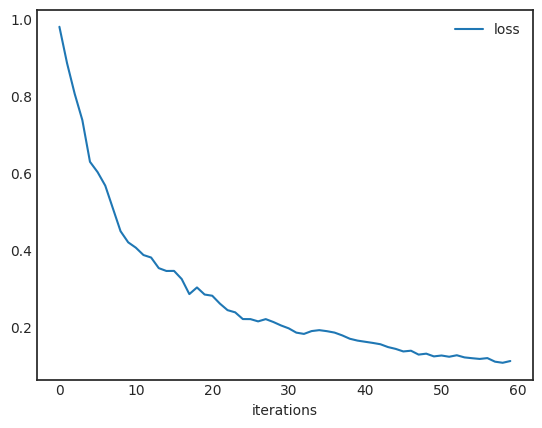

In [141]:
plt.plot(loss,label = "loss")
plt.xlabel("iterations")
plt.legend()

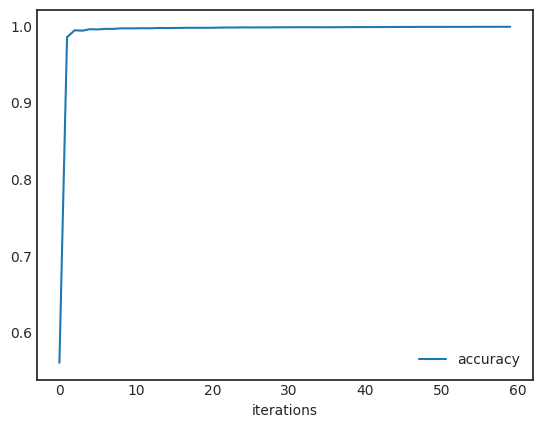

In [142]:
plt.plot(accuracy,label = "accuracy")
plt.xlabel("iterations")
plt.legend()

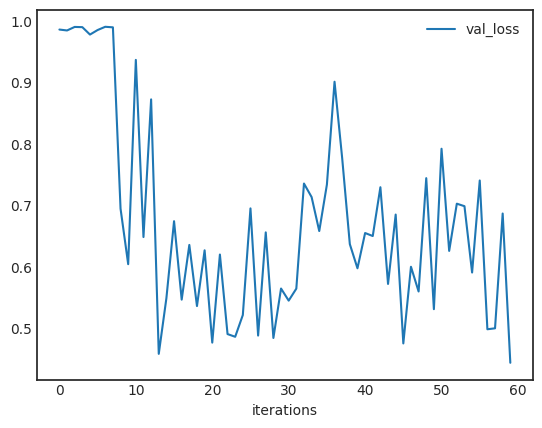

In [143]:
plt.plot(val_loss,label = "val_loss")
plt.xlabel("iterations")
plt.legend()

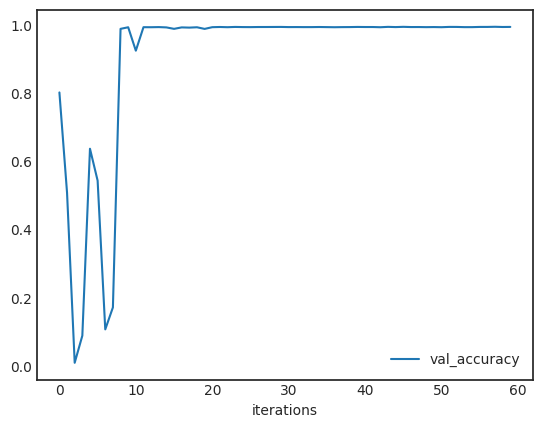

In [144]:
plt.plot(val_accuracy,label = "val_accuracy")
plt.xlabel("iterations")
plt.legend()

In [131]:
model.save_weights('top.weights.h5')

In [145]:
def make_prediction(model,image,shape):
    img = img_to_array(load_img(image,target_size=shape))
    img = np.expand_dims(img,axis=0)/255.
    mask = model.predict(img)

    mask = np.reshape(mask,(224,224,1))
    return mask

347.png


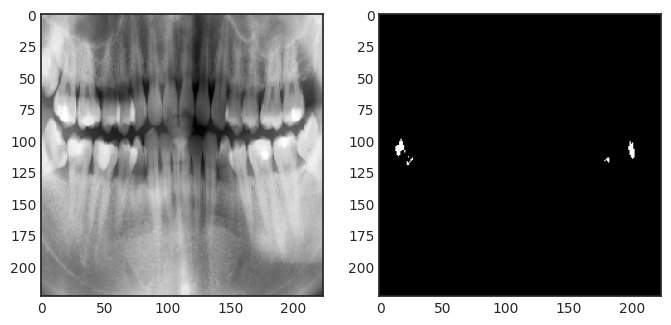

In [158]:
test_image_path = train_files[10]

image = './images_cut/' + test_image_path
img = img_to_array(load_img(image, target_size=(224,224,3)))/255

mask = './labels_cut/' + test_image_path
mask_img = img_to_array(load_img(mask, target_size=(224,224,3)))

print(test_image_path)

plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(mask_img/255.)

1/1 [==============================] - 0s 22ms/step


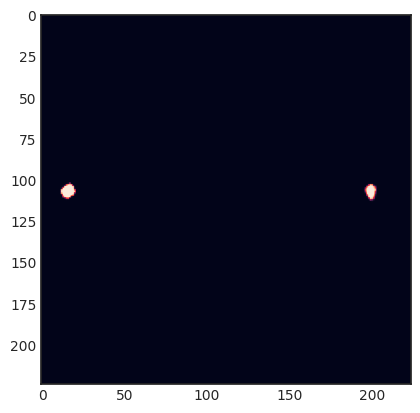

In [159]:
mask = make_prediction(model,image,(224,224))
plt.imshow(mask)